In [1]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

In [2]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_tabletop/planar_tabletop_lines_scenes_test/"

scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(4575, 5)
means:  [-0.00872321  0.00444568  3.14011483  0.19929218  0.20043479]
vars:  [0.26627299 0.2677912  1.81480141 0.05737896 0.05760085]
2d_sphere : 
(4392, 4)
means:  [2.75008170e-03 6.42149609e-03 3.15556028e+00 1.00161050e-01]
vars:  [0.26640715 0.26215936 1.80700842 0.0287064 ]


In [110]:
print len(scenes_dataset_yaml)

2987


In [3]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TRAIN, max_num_objects=5,
    base_environment_type="planar_tabletop")
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(
    DATA_DIR_TEST,max_num_objects=5,
    base_environment_type="planar_tabletop")
data_test = scenes_dataset_test.get_full_dataset()

print "Train batch size: ", data.batch_size
print "Test batch size: ", data_test.batch_size

Train batch size:  2987
Test batch size:  746


In [27]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter
from scene_generation.models.planar_multi_object_multi_class_2_with_context import MultiObjectMultiClassModelWithContext

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/planar_tabletop_lines/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)

pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
pyro.get_param_store().save("planar_multi_object_multi_class_2_with_context_lines_untrained.pyro")
#guide = AutoDelta(poutine.block(model.model, hide=["obs"]))

scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.01, 'betas': [0.9, 0.99], 'weight_decay': 1E-3},
      "step_size": 100,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
losses = []
losses_test = []
best_on_test_loss = 0
best_test_loss = np.infty
cycles_since_improvement = 0

snapshots = {}
for i in range(5000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=100) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=100) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if i > 300 and cycles_since_improvement > 100:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 10 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))
print "Done"

Iter: 0, Loss: 36.702415, Loss_test: 23.698507, Best test loss: 23.698507, Time per step: 0.466686
Iter: 10, Loss: 7.498234, Loss_test: 5.935175, Best test loss: 5.935175, Time per step: 0.242294
Iter: 20, Loss: 4.133192, Loss_test: 3.328199, Best test loss: 2.996846, Time per step: 0.317201
Iter: 30, Loss: 3.487868, Loss_test: 3.449046, Best test loss: 2.795092, Time per step: 0.269012
Iter: 40, Loss: 2.998401, Loss_test: 2.855738, Best test loss: 2.529526, Time per step: 0.408470
Iter: 50, Loss: 2.814628, Loss_test: 2.597519, Best test loss: 2.476599, Time per step: 0.460337
Iter: 60, Loss: 2.287477, Loss_test: 2.217146, Best test loss: 2.217146, Time per step: 0.331040
Iter: 70, Loss: 2.400996, Loss_test: 2.114447, Best test loss: 1.795901, Time per step: 0.434650
Iter: 80, Loss: 1.793091, Loss_test: 1.768222, Best test loss: 1.535211, Time per step: 0.275483
Iter: 90, Loss: 0.602446, Loss_test: 1.524064, Best test loss: 0.817454, Time per step: 0.266583
Iter: 100, Loss: 0.437921, L

In [104]:
cycles_since_improvement = 0
scheduler = pyro.optim.StepLR(
    {"optimizer": torch.optim.Adam,
     "optim_args": {'lr': 0.0001, 'betas': [0.9, 0.99]},
      "step_size": 50,
      "gamma": 0.1
    })
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, scheduler, loss=elbo)
for i in range(2000):
    start_time = time.time()
    loss = svi.step(data, subsample_size=100) / data.batch_size
    losses.append(loss)
    writer.add_scalar('loss', loss, i)

    loss_test = svi.evaluate_loss(data_test, subsample_size=100) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    if loss_test < best_test_loss:
        best_on_test_loss = pyro.get_param_store().get_state()
        best_test_loss = loss_test
        cycles_since_improvement = 0
    else:
        cycles_since_improvement += 1
        if cycles_since_improvement > 200:
            print("Terminating early due to rising test loss")
            break

    #for p in interesting_params:
    #    write_np_array(writer, p, snapshots[p][-1], i)
    end_time = time.time()
    if (i % 10 == 0):
        print("Iter: %d, Loss: %f, Loss_test: %f, Best test loss: %f, Time per step: %f" % (
            i, loss, loss_test, best_test_loss, end_time - start_time))

Iter: 0, Loss: -2.163430, Loss_test: -2.374496, Best test loss: -2.911282, Time per step: 0.317034
Iter: 10, Loss: -2.565240, Loss_test: -2.161498, Best test loss: -2.911282, Time per step: 0.319933
Iter: 20, Loss: -2.264734, Loss_test: -2.175169, Best test loss: -2.911282, Time per step: 0.298858
Iter: 30, Loss: -2.067265, Loss_test: -2.741053, Best test loss: -2.911282, Time per step: 0.419543
Iter: 40, Loss: -2.353015, Loss_test: -2.471327, Best test loss: -2.911282, Time per step: 0.327722
Iter: 50, Loss: -2.510762, Loss_test: -2.569403, Best test loss: -2.911282, Time per step: 0.510890
Iter: 60, Loss: -2.556330, Loss_test: -2.190214, Best test loss: -2.911282, Time per step: 0.296864
Iter: 70, Loss: -2.789084, Loss_test: -2.481433, Best test loss: -2.911282, Time per step: 0.315962
Iter: 80, Loss: -2.170895, Loss_test: -1.920933, Best test loss: -2.911282, Time per step: 0.306988
Iter: 90, Loss: -1.668306, Loss_test: -2.802224, Best test loss: -2.911282, Time per step: 0.302238
I

('Model evaluated on all of test: ', -0.9612153490490952)


Parameter containing:
tensor([ 8.7827e-02, -1.0008e-01,  1.6590e-01,  9.1219e-02, -9.2594e-02,
        -5.6438e-02,  6.1882e-03, -5.6831e-02,  1.2392e-01, -2.1067e-02,
         3.7395e-02, -4.4615e-02,  1.6868e-02, -6.9825e-02, -3.3592e-02,
        -1.1151e-05, -6.8943e-02,  1.1592e-01, -1.5006e-01, -1.0576e-01,
         2.6454e-01, -1.8738e-01,  1.9518e-01,  1.8221e-01,  2.4764e-01,
        -4.8085e-02,  4.1461e-02, -5.2182e-02, -1.1928e-01, -5.7486e-02,
         1.9611e-01, -1.0995e-01, -9.3268e-02,  1.9089e-01, -8.9173e-02,
        -1.4143e-01, -1.1146e-01, -1.2850e-01, -1.4093e-01, -2.1956e-01,
         1.6200e-01, -9.7990e-02,  7.1271e-02,  4.6763e-02,  1.6229e-02,
         3.6736e-02, -2.9318e-01, -1.3612e-01,  1.7961e-01,  1.1686e-01],
       requires_grad=True)

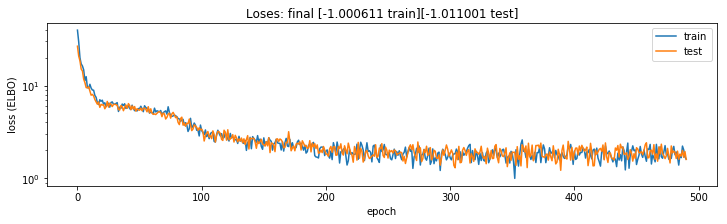

In [28]:
plt.figure().set_size_inches(12, 3)
offset = min(np.min(losses), np.min(losses_test))
plt.plot(losses - offset + 1., label="train")
plt.plot(losses_test - offset + 1., label="test")
plt.semilogy()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss (ELBO)")
plt.title("Loses: final [%f train][%f test]" % (np.mean(losses[-20:]), np.mean(losses_test[-20:])))
print("Model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)


pyro.param("class_1_flow_4$$$arn.layers.0.bias")

In [94]:
# Save model
pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_lines_without_projection.pyro")
#pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_stacks_with_projection_constraints.pyro")

In [72]:
pyro.clear_param_store()
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_lines_without_projection.pyro")
pyro.param("class_1_flow_4$$$arn.layers.0.bias")

Parameter containing:
tensor([-0.1539,  0.2435, -0.0581, -0.0203,  0.1243,  0.1056, -0.0849, -0.0459,
        -0.1275, -0.1535, -0.0733,  0.2119,  0.0554,  0.2571,  0.0364, -0.0883,
         0.1619,  0.0527, -0.2748, -0.2568], requires_grad=True)

In [73]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModelWithContext(scenes_dataset, use_projection=False)
print "All params pre load: ", pyro.get_param_store().get_all_param_names()
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_lines_without_projection.pyro")
print "All params post load: ", pyro.get_param_store().get_all_param_names()

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, model.guide, optim, loss=elbo)
print("Loaded model evaluated on all of test: ",
      svi.evaluate_loss(data_test) / data_test.batch_size)

print(model.class_flows[1][4].arn)
pyro.param("class_1_flow_4$$$arn.layers.0.bias")

All params pre load:  []
All params post load:  ['class_1_flow_4$$$arn.layers.0.bias', 'context_updater_module$$$weight_hh_l0', 'class_0_flow_1$$$arn.layers.2.bias', 'class_1_flow_1$$$arn.layers.0.weight', 'class_encoder_module_1$$$4.bias', 'class_1_flow_3$$$arn.layers.2.bias', 'context_updater_module$$$weight_ih_l0', 'class_1_flow_2$$$arn.layers.0.weight', 'class_encoder_module_0$$$2.weight', 'class_controller_module$$$0.bias', 'class_1_flow_0$$$arn.layers.1.weight', 'class_1_flow_0$$$arn.layers.0.bias', 'class_encoder_module_0$$$4.weight', 'class_1_flow_3$$$arn.layers.0.weight', 'class_1_flow_0$$$arn.layers.2.weight', 'class_0_flow_2$$$arn.layers.0.bias', 'class_encoder_module_0$$$0.bias', 'class_encoder_module_1$$$2.weight', 'class_1_flow_2$$$arn.layers.0.bias', 'class_1_flow_2$$$arn.layers.2.weight', 'keep_going_controller_module$$$4.bias', 'class_1_flow_0$$$arn.layers.2.bias', 'class_0_flow_0$$$arn.layers.2.bias', 'class_1_flow_1$$$arn.layers.1.weight', 'class_0_flow_4$$$arn.layer

Parameter containing:
tensor([-0.1539,  0.2435, -0.0581, -0.0203,  0.1243,  0.1056, -0.0849, -0.0459,
        -0.1275, -0.1535, -0.0733,  0.2119,  0.0554,  0.2571,  0.0364, -0.0883,
         0.1619,  0.0527, -0.2748, -0.2568], requires_grad=True)

Process PoolWorker-876:
Process PoolWorker-864:
Process PoolWorker-870:
Process PoolWorker-878:
Traceback (most recent call last):
Traceback (most recent call last):
Process PoolWorker-877:
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process PoolWorker-869:
Process PoolWorker-867:
    self.run()
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/multiprocessing/process.py", line 267, in _bo

In [15]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(10):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_tabletop")
    time.sleep(1.0)

{'obj_0000': {'color': [0.6718895548454389, 0.0, 1.0, 1.0], 'pose': [0.2658050060272217, 0.09113036841154099, 1.6047576665878296], 'params': [0.15712645649909973, 0.17828087508678436], 'class': '2d_box', 'params_names': ['height', 'length']}, 'n_objects': 1}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.


/home/gizatt/projects/scene_generation/data/dataset_utils.py:244: DrakeDeprecationWarning: This API using Isometry3 will be deprecated soon with the resolution of #9865. We only offer it for backwards compatibility. DO NOT USE!.
    Please see `help(pydrake.common.deprecation)` for more information.
  mbp.RegisterVisualGeometry(body, pose, shape, name + "_vis", color)
/home/gizatt/drake/build/install/lib/python2.7/site-packages/pydrake/systems/meshcat_visualizer.py:280: DrakeDeprecationWarning: '_DoPublish' is deprecated and will be removed on or around 2019-06-15. Please call 'DoPublish' instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  LeafSystem.DoPublish(self, context, event)
/home/gizatt/projects/scene_generation/data/dataset_utils.py:483: DrakeDeprecationWarning: '_DoPublish' is deprecated and will be removed on or around 2019-06-15. Please call 'DoPublish' instead.
    Please see `help(pydrake.common.deprecation)` for more information.
  visualiz

{'obj_0000': {'color': [0.5133260371920199, 0.0, 1.0, 1.0], 'pose': [-0.24481645226478577, 0.3777028024196625, 3.5520923137664795], 'params': [0.23097443580627441, 0.1973598301410675], 'class': '2d_box', 'params_names': ['height', 'length']}, 'n_objects': 1}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Connected to meshcat-server.
{'obj_0000': {'color': [0.5880593995109356, 0.0, 1.0, 1.0], 'pose': [0.060550980269908905, 0.21185879409313202, 3.1816372871398926], 'params': [0.13615547120571136], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0001': {'color': [0.6935260045050406, 0.0, 1.0, 1.0], 'pose': [0.19273528456687927, 0.4630749225616455, 1.2996619939804077], 'params': [0.12319347262382507], 'class': '2d_sphere', 'params_names': ['radius']}, 'n_objects': 2}
Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the foll

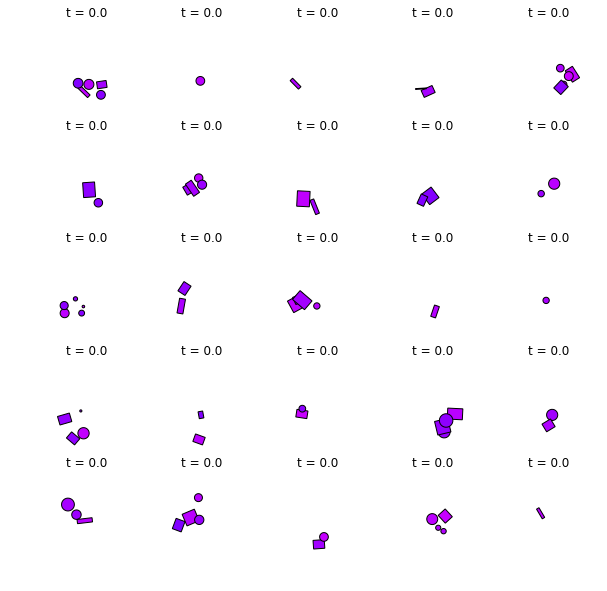

In [38]:
# Convert that data back to a YAML environment, which is easier to
# handle.
side_width = 5
generated_data, generated_encodings, generated_contexts = model.model()
scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
    generated_data)
plt.figure().set_size_inches(10, 10)
for k in range(side_width):
    for l in range(side_width):
        plt.subplot(side_width, side_width, k*side_width+l+1)
        dataset_utils.DrawYamlEnvironmentPlanar(scene_yaml[k*side_width+l+1], "planar_tabletop", ax=plt.gca())

[5, 4, 2, 2, 4, 1, 2, 5, 1, 5, 3, 5, 3, 3, 2, 2, 3, 2, 1, 1, 3, 2, 4, 4, 3, 5, 1, 1, 5, 1, 3, 5, 3, 5, 5, 4, 1, 3, 1, 4, 1, 1, 4, 4, 3, 1, 4, 5, 5, 3, 2, 3, 3, 3, 1, 5, 1, 3, 5, 4, 3, 4, 2, 3, 2, 3, 1, 5, 1, 4, 5, 4, 1, 1, 5, 3, 4, 4, 2, 4, 5, 4, 1, 4, 1, 3, 4, 1, 5, 3, 3, 5, 1, 4, 3, 5, 3, 4, 3, 1, 5, 4, 3, 3, 4, 1, 1, 4, 3, 5, 1, 3, 3, 1, 2, 1, 1, 3, 5, 2, 4, 2, 1, 4, 4, 3, 2, 4, 4, 1, 4, 1, 2, 2, 2, 2, 3, 4, 2, 1, 1, 1, 4, 5, 1, 3, 1, 2, 4, 5, 4, 2, 2, 2, 5, 2, 3, 1, 3, 5, 3, 4, 4, 2, 1, 4, 4, 2, 4, 5, 2, 1, 4, 2, 4, 5, 2, 4, 1, 2, 5, 5, 4, 4, 4, 3, 5, 3, 5, 4, 3, 3, 2, 3, 2, 3, 5, 3, 3, 5, 4, 4, 5, 5, 3, 4, 5, 4, 5, 1, 3, 4, 5, 4, 2, 3, 3, 1, 3, 5, 3, 3, 2, 5, 3, 3, 4, 5, 5, 1, 1, 5, 1, 4, 3, 2, 3, 1, 3, 3, 5, 3, 4, 5, 5, 2, 3, 5, 4, 3, 4, 2, 4, 3, 5, 2, 3, 4, 4, 1, 5, 4, 1, 5, 2, 2, 2, 5, 2, 3, 5, 2, 2, 2, 4, 2, 1, 2, 2, 3, 4, 3, 4, 4, 3, 2, 4, 4, 4, 5, 4, 3, 4, 3, 5, 4, 3, 2, 5, 5, 4, 4, 2, 4, 4, 4, 2, 3, 4, 5, 1, 3, 5, 2, 1, 3, 3, 5, 1, 4, 3, 1, 1, 3, 1, 5, 3, 4, 4, 4, 2, 5, 3, 

Text(0,0.5,'Count')

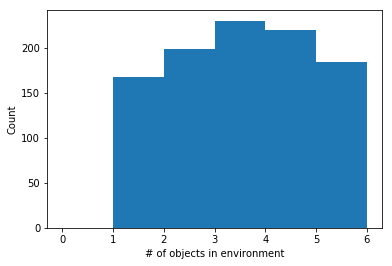

In [29]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    [generated_n_objs.append(scene["n_objects"]) for scene in scene_yaml]
print generated_n_objs
plt.hist(generated_n_objs, bins=range(7))
plt.xlabel("# of objects in environment")
plt.ylabel("Count")

In [30]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

# Generate some examples
scene_yaml = []
for k in range(20):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml += scenes_dataset.convert_vectorized_environment_to_yaml(generated_data)
params_by_object_class_nonpen = generate_params_by_object_class(scene_yaml)

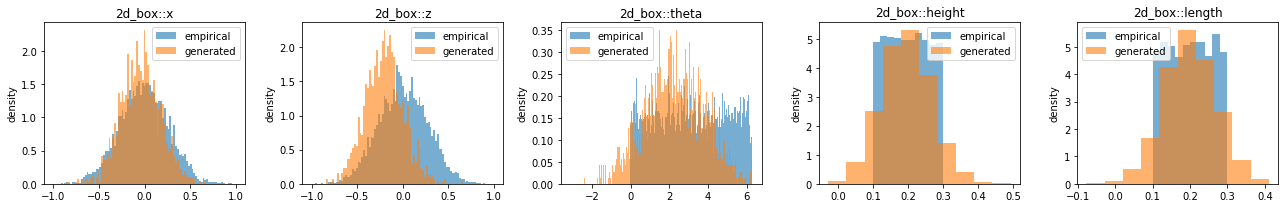

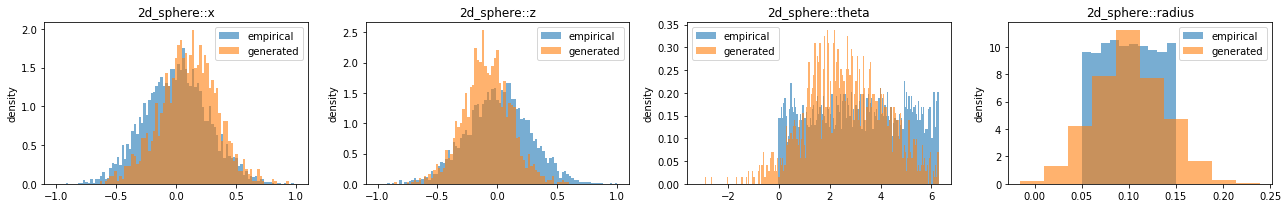

In [31]:
for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        params_by_object_class_nonpen[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "generated"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[:, 2] = ((params_stacked[:, 2] + 2 * np.pi) % (2 * np.pi) - np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(-1., 1., 100)
        elif k == 2:
            bins = np.linspace(-np.pi, 2*np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.6)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()